The notebooks shows how to calculate intrinsic timescales on the continious and epoched data. Four methods are used.

In [1]:
import numpy as np
import pandas as pd
import pickle
from itertools import islice
from statsmodels.tsa.stattools import acf
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

import os
current_wd = os.getcwd()
os.chdir(os.path.abspath("..\\..\\isttc\\scripts"))
from spike_train_utils import bin_spike_train_fixed_len
from calculate_acf import acf_pearsonr_trial_avg, acf_sttc_trial_concat, acf_sttc
from calculate_tau import fit_single_exp, func_single_exp_monkey
os.chdir(current_wd)

In [2]:
log_every = 10

fs = 1000 # sampling frequency 
bin_size = int(50 * (fs / 1000)) # 50 ms bin
trial_len = int(1000 * (fs / 1000)) # 1000 ms trial

sttc_dt = int(25 * (fs / 1000)) # dt for isttc 
n_lags = 20 # number of lags for acf calculation

### Load data

In [3]:
# spike trains
with open('spike_trains.pkl', 'rb') as f:
    data = pickle.load(f)

spike_trains = data['spike_trains']
signal_len = data['duration_ms']
print(f'n spike trains {len(spike_trains)}, len {signal_len}')

# trials
with open('trials.pkl', 'rb') as f:
    trials = pickle.load(f)

with open('trials_binned.pkl', 'rb') as f:
    trials_binned = pickle.load(f)

n spike trains 100, len 600000


### Calculate intrinsic timescale using 4 methods

In [4]:
def extract_all_taus(acfs, exp_fun, log_every=2):
    results = {}
    for idx, unit_acf in enumerate(acfs):
        if idx % log_every == 0:
            print(f'#####\nProcessing tau for unit {idx + 1}/{len(acfs)}, {datetime.now()}')
        
        fit_popt, fit_pcov, tau, tau_ci, fit_r_squared, explained_var, log_message = fit_single_exp(
            unit_acf, start_idx_=1, exp_fun_=exp_fun)
        
        results[idx] = {
            'taus': {
                'tau': tau,
                'tau_lower': tau_ci[0],
                'tau_upper': tau_ci[1],
                'fit_r_squared': fit_r_squared,
                'popt': fit_popt,
                'pcov': fit_pcov,
                'log_message': log_message
            },
            'acf': unit_acf
        }
    return results

def build_acf_summary_df(acf_dict, method, fr_values, alphas, taus_ms, tau_ms_bin_size=50):
    """Construct summary df with tau and fit metrics."""
    data = []
    for unit_id, unit_data in acf_dict.items():
        taus = unit_data['taus']
        data.append({
            'unit_id': unit_id,
            'tau': taus['tau'],
            'fit_r_squared': taus['fit_r_squared']
        })
    
    df = pd.DataFrame(data)
    df['tau_ms'] = df['tau'] * tau_ms_bin_size    
    df['method'] = method
    df['fr'] = fr_values
    df['alpha'] = alphas
    df['tau_ms_true'] = taus_ms
    df['tau_diff_abs'] = np.abs(df['tau_ms'] - df['tau_ms_true'])
    df['tau_diff_rel'] = df['tau_diff_abs'] / df['tau_ms_true'] * 100

    return df

#### ACF

In [5]:
# bin
all_spike_trains_binned_l = [
    bin_spike_train_fixed_len([int(spike) for spike in train], bin_size, fs, signal_len, verbose_=False)
    for train in spike_trains
]

# get acf
print(f'Calculating ACF...')
acf_full_l = []
for idx, unit in enumerate(all_spike_trains_binned_l):
    if idx % log_every == 0:
        print(f'#####\nProcessing acf for unit {idx + 1}/{len(all_spike_trains_binned_l)}, {datetime.now()}')
    acf_full_l.append(acf(unit, nlags=n_lags))

# get tau
print(f'\nCalculating tau...')
acf_full_dict = extract_all_taus(acf_full_l, func_single_exp_monkey, log_every)

acf_full_df = build_acf_summary_df(acf_full_dict, 'acf', data['fr_values'], data['alphas'], data['tau_ms'], tau_ms_bin_size=50)

Calculating ACF...
#####
Processing acf for unit 1/100, 2025-08-04 16:13:35.941885
#####
Processing acf for unit 11/100, 2025-08-04 16:13:35.952885
#####
Processing acf for unit 21/100, 2025-08-04 16:13:35.961885
#####
Processing acf for unit 31/100, 2025-08-04 16:13:35.970885
#####
Processing acf for unit 41/100, 2025-08-04 16:13:35.979885
#####
Processing acf for unit 51/100, 2025-08-04 16:13:35.988885
#####
Processing acf for unit 61/100, 2025-08-04 16:13:35.997894
#####
Processing acf for unit 71/100, 2025-08-04 16:13:36.006894
#####
Processing acf for unit 81/100, 2025-08-04 16:13:36.015415
#####
Processing acf for unit 91/100, 2025-08-04 16:13:36.024413

Calculating tau...
#####
Processing tau for unit 1/100, 2025-08-04 16:13:36.033413
#####
Processing tau for unit 11/100, 2025-08-04 16:13:36.070413
#####
Processing tau for unit 21/100, 2025-08-04 16:13:36.110944
#####
Processing tau for unit 31/100, 2025-08-04 16:13:36.146944
#####
Processing tau for unit 41/100, 2025-08-04 16:1

#### iSTTC

In [6]:
# get acf
acf_isttc_full_l = []
for idx, unit in enumerate(spike_trains):
    if idx % log_every == 0:
        print(f'#####\nProcessing acf for unit {idx + 1}/{len(spike_trains)}, {datetime.now()}')
    spike_train_int = np.asarray([int(spike) for spike in unit])
    acf_isttc_full = acf_sttc(spike_train_int, n_lags, bin_size, sttc_dt, signal_len, verbose_=False)
    acf_isttc_full_l.append(acf_isttc_full)

# get tau
print(f'\nCalculating tau...')
isttc_full_dict = extract_all_taus(acf_isttc_full_l, func_single_exp_monkey, log_every)

isttc_full_df = build_acf_summary_df(isttc_full_dict, 'isttc', data['fr_values'], data['alphas'], data['tau_ms'], tau_ms_bin_size=50)

#####
Processing acf for unit 1/100, 2025-08-04 16:14:12.586219
#####
Processing acf for unit 11/100, 2025-08-04 16:14:13.756146
#####
Processing acf for unit 21/100, 2025-08-04 16:14:14.826592
#####
Processing acf for unit 31/100, 2025-08-04 16:14:15.946395
#####
Processing acf for unit 41/100, 2025-08-04 16:14:17.099086
#####
Processing acf for unit 51/100, 2025-08-04 16:14:18.215820
#####
Processing acf for unit 61/100, 2025-08-04 16:14:19.322441
#####
Processing acf for unit 71/100, 2025-08-04 16:14:20.476748
#####
Processing acf for unit 81/100, 2025-08-04 16:14:21.607507
#####
Processing acf for unit 91/100, 2025-08-04 16:14:22.683193

Calculating tau...
#####
Processing tau for unit 1/100, 2025-08-04 16:14:23.771330
#####
Processing tau for unit 11/100, 2025-08-04 16:14:23.808331
#####
Processing tau for unit 21/100, 2025-08-04 16:14:23.844365
#####
Processing tau for unit 31/100, 2025-08-04 16:14:23.878938
#####
Processing tau for unit 41/100, 2025-08-04 16:14:23.913943
#####
P

#### PearsonR

In [7]:
trial_binned_dict = trials_binned['trial_dict']

# get acf
m_iterations = 1
pearsonr_trial_avg_l = []
for k, v in trial_binned_dict.items():
    for m in range(m_iterations):
        spikes_trials_binned = trial_binned_dict[k][m]
        pearsonr_acf_matrix, pearsonr_acf_average = acf_pearsonr_trial_avg(spikes_trials_binned,
                                                                           n_lags,
                                                                           verbose_=False)
        pearsonr_trial_avg_l.append(pearsonr_acf_average)
   
# get tau
print(f'\nCalculating tau...')
pearsonr_full_dict = extract_all_taus(pearsonr_trial_avg_l, func_single_exp_monkey, log_every)

pearsonr_full_df = build_acf_summary_df(pearsonr_full_dict, 'pearsonr', data['fr_values'], data['alphas'], data['tau_ms'], tau_ms_bin_size=50)

ERROR: Pearson r can not be calculated for i=0, j=8, error An input array is constant; the correlation coefficient is not defined.
ERROR: Pearson r can not be calculated for i=0, j=9, error An input array is constant; the correlation coefficient is not defined.
ERROR: Pearson r can not be calculated for i=0, j=10, error An input array is constant; the correlation coefficient is not defined.
ERROR: Pearson r can not be calculated for i=1, j=8, error An input array is constant; the correlation coefficient is not defined.
ERROR: Pearson r can not be calculated for i=1, j=9, error An input array is constant; the correlation coefficient is not defined.
ERROR: Pearson r can not be calculated for i=1, j=10, error An input array is constant; the correlation coefficient is not defined.
ERROR: Pearson r can not be calculated for i=2, j=8, error An input array is constant; the correlation coefficient is not defined.
ERROR: Pearson r can not be calculated for i=2, j=9, error An input array is cons

#### iSTTC (trials)

In [8]:
trial_dict = trials['trial_dict']

# get acf
sttc_concat_acf_l= []
for k, v in trial_dict.items():
    for m in range(m_iterations):
        spikes_trials = trial_dict[k][m]
        acf_concat = acf_sttc_trial_concat(spikes_trials,
                                           n_lags_=n_lags,
                                           lag_shift_=bin_size,
                                           sttc_dt_=sttc_dt,
                                           trial_len_=trial_len,
                                           zero_padding_len_=int(3*trial_len * (fs / 1000)),
                                           verbose_=False)
        sttc_concat_acf_l.append(acf_concat)

# get tau
print(f'\nCalculating tau...')
isttc_trials_dict = extract_all_taus(sttc_concat_acf_l, func_single_exp_monkey, log_every)

isttc_trials_df = build_acf_summary_df(isttc_trials_dict, 'isttc_trials', data['fr_values'], data['alphas'], data['tau_ms'], tau_ms_bin_size=50)


Calculating tau...
#####
Processing tau for unit 1/100, 2025-08-04 16:14:36.366477
#####
Processing tau for unit 11/100, 2025-08-04 16:14:36.410477
#####
Processing tau for unit 21/100, 2025-08-04 16:14:36.453521
#####
Processing tau for unit 31/100, 2025-08-04 16:14:36.495082
#####
Processing tau for unit 41/100, 2025-08-04 16:14:36.538092
#####
Processing tau for unit 51/100, 2025-08-04 16:14:36.580698
#####
Processing tau for unit 61/100, 2025-08-04 16:14:36.624698
#####
Processing tau for unit 71/100, 2025-08-04 16:14:36.749970
#####
Processing tau for unit 81/100, 2025-08-04 16:14:36.798546
#####
Processing tau for unit 91/100, 2025-08-04 16:14:36.840546


#### Combine all dfs

In [9]:
tau_df = pd.concat([acf_full_df, isttc_full_df, pearsonr_full_df, isttc_trials_df])
tau_df.reset_index(inplace=True, drop=True)
tau_df['tau_diff_rel_log10'] = np.log10(tau_df['tau_diff_rel'])
tau_df['tau_ms_log10'] = np.log10(tau_df['tau_ms'])
tau_df.head(2)

,unit_id,tau,fit_r_squared,tau_ms,method,fr,alpha,tau_ms_true,tau_diff_abs,tau_diff_rel,tau_diff_rel_log10,tau_ms_log10
0,0,2.428278,0.995256,121.413910,acf,2,0.7,100.0,21.413910,21.413910,1.330696,2.084268
1,1,1.694971,0.966358,84.748547,acf,2,0.7,100.0,15.251453,15.251453,1.183311,1.928132


### Plots

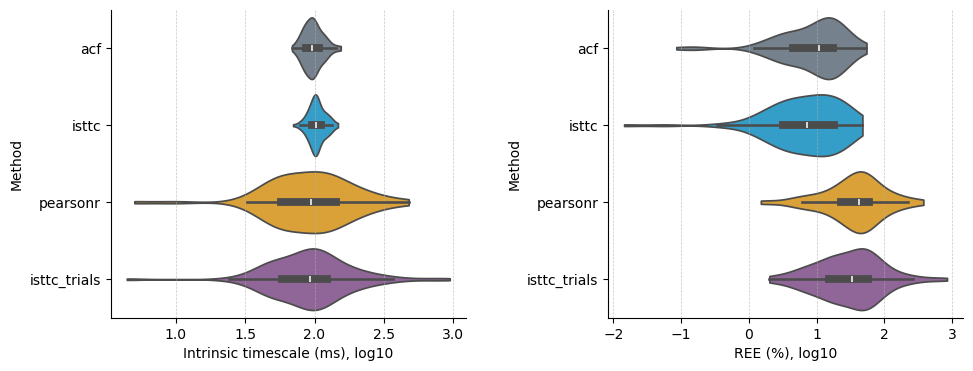

In [10]:
# Estimated taus and REE
colors = ['#718190', '#1ba9e2', '#f4a91c' , '#955da2' ]
method_order = ['acf', 'isttc', 'pearsonr', 'isttc_trials']

fig, axes = plt.subplots(1,2, figsize=(11, 4))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

sns.violinplot(y='method', x='tau_diff_rel_log10', hue='method', order=method_order, hue_order=method_order, 
               palette=colors, data=tau_df , cut=0, ax=axes[1])
axes[1].set_xlabel('REE (%), log10')

sns.violinplot(y='method', x='tau_ms_log10', hue='method', order=method_order, hue_order=method_order, 
               palette=colors, data=tau_df , cut=0, ax=axes[0])
axes[0].set_xlabel('Intrinsic timescale (ms), log10')

for ax in axes.flat:
    ax.grid(True, which="both", axis='x', linestyle="--", linewidth=0.5, alpha=0.7)
    ax.set_ylabel('Method')

sns.despine()